In [328]:
import numpy as np
import scipy.stats as sps
import scipy

from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

Let's suppose that the kernel function is the discretized Green's function for the negative Laplace operator $\mathcal{L}u = -d^2u / dx^2$.

For this operator matrix $L$ (with size $N \times N$) we have eigenvalues $\lambda_i = \pi^2 n^2$ and correspondings eigenfunctions $f_i(x) = \sqrt{2} \sin(\pi n x)$. So $Lf_i = \lambda_i f_i$. 

Hence, $G(x, y) = \sum\limits_{i = 1}^N \frac{f_i(x) f_i(y)}{\lambda_i}$ is the Green's function for the negative Laplace operator.

In [391]:
def kernel_func(x, y, N=100):
    # let's define the kernel 
    res = 0
    for n in range(1, N + 1):
        res += np.sin(np.pi * n * x) * np.sin(np.pi * n * y) * 2 / (np.pi * n) ** 2

    return res

In [392]:
def get_cov_matrix_from_grid(kernel_func, N=10, x_left=0, x_right=1, 
                             y_left=0, y_right=1):
    # create grid
    x_grid = np.linspace(x_left, x_right, N)
    y_grid = np.linspace(y_left, y_right, N)

    x_points, y_points = [curr.ravel() for curr in np.meshgrid(x_grid, y_grid)]

    # kernel values on uniform grid [x_left, x_right] x [y_left, y_right]
    K = kernel_func(x_points, y_points, N=N).reshape((N, N)) 
    K += 1e-5 * np.eye(N) # just for stability

    return K

Sample variables from the normal distribution with constucted kernel:

In [393]:
def get_norm_variables(K, k_size=3):
    # K is the symmetric positive definite
    assert K.shape[0] == K.shape[1], 'K is not a squared matrix'

    N = K.shape[0]
   
    f = sps.multivariate_normal(mean=np.zeros(K.shape[0]), cov=K).rvs(size=k_size).T
    assert f.shape == (N, k_size)

    return f

Test previous functions:

In [394]:
K = get_cov_matrix_from_grid(kernel_func, N=4)
f = get_norm_variables(K)

# observe results
np.linalg.eigvals(K)

array([1.00000000e-05, 3.03973551e-01, 9.49986097e-02, 1.00000000e-05])

**Randomized SVD**

Given an $m × n$ matrix A, a target number k of singular vectors, and an exponent q (say, q = 1 or q = 2), this procedure computes an approximate rank-2k factorization $UΣV^*$, where U and V are orthonormal, and Σ is nonnegative and diagonal. 

**Stage 1:**

1. Generate an n × 2k Gaussian test matrix $\Omega$.
2. Form $Y = (AA*)^qAΩ$ by multiplying alternately with A and A*.
3. Construct a matrix Q whose columns form an orthonormal basis for the range of Y .

**Stage 2:**

4. Form $B = Q^{*}A$
5. Compute an SVD of the small matrix: $B = ÜΣV^*$
6. Set $U = QÜ$

**Note:** The computation of <b>Y</b> in step 2 is vulnerable to round-off errors.
When high accuracy is required, we must incorporate an orthonormalization
step between each application of <b>A</b> and <b>A*</b>.

In [482]:
class random_matrix_generator:
    def __init__(self, distr=sps.norm()):
        self.distr = distr

    def rvs(self, n, k):
        return self.distr.rvs(size=(n, 2 * k))


class gaussian_matrix_generator:
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func
    
    def rvs(self, n, k):
        K = get_cov_matrix_from_grid(self.kernel_func, N=n)
        f = get_norm_variables(K, 2 * k)

        return f

def svd(B):  
    # scipy is a little bit faster than numpy (but negligible ...) 
    u, s, vh = scipy.linalg.svd(B, full_matrices=False)
    return u, s, vh

def random_svd(A, k, q, matrix_generator):
    # STAGE 1:
    
    # generate n x 2k gaussian test matrix Gamma
    gamma = matrix_generator.rvs(A.shape[1], k)  #
    
    # because of round-off errors, we will make second QR-decomposition on each step
    Y0 = np.dot(A, gamma)
    if q > 0:
        for i in range(q):
            Y_temporary, _ = np.linalg.qr(np.dot(A.T, Y0))
            Q, _ = np.linalg.qr(np.dot(A, Y_temporary))
    else:
        # Construct a matrix Q whose columns form an orthonormal basis for the range of Y
        Q, _ = np.linalg.qr(Y0)    
        
    # STAGE 2:
    
    # Form B = Q*A.
    B = np.dot(Q.T, A)
    
    # Compute an SVD of the small matrix: B = ÜΣV*.
    U_prime, Epsilon, V_adj = svd(B)
    
    # Set U = Q * U_prime
    U = np.dot(Q, U_prime)
    
    # Truncate -> Get the Good rank k not 2 * k...
    U, Epsilon, V_adj = U[:, :k], Epsilon[:k], V_adj[:k, :]
    
    return U, Epsilon, V_adj

Let's make the experiment! We wan't to learn the disсretized Green's function< of the following differential operator: $\mathcal{L}u = d^2u / dx^2 - C \cdot \sin(Kx)\cdot u$, $x \in [0, 1]$.

We compute this Green's function and obtain that:

$$
G(x, s) = \frac{1}{2} \frac{sin(\sqrt{C \cdot \sin(Ks)} \cdot (x - s))}{\sqrt{C \cdot \sin(Ks)}}
$$

Suppose $C = 4$ and $K = \pi$:

In [484]:
C = 4
K = np.pi

def get_Green_matrix(x, s, C=C, K=K):
    return 1/2 * np.sin(np.sqrt(C * np.sin(K * x)) * (x - s)) / np.sqrt(C * np.sin(K * x))

x_vals = np.linspace(0.001, 1, 200)

ar1, ar2 = [curr.ravel() for curr in np.meshgrid(x_vals, x_vals)]


A = get_Green_matrix(ar1, ar2).reshape((200, 200)) + sps.norm().rvs((200, 200))

In [485]:
n_restarts = 5 # average by 5 restarts

gaussian_errors = []
random_errors = []

# number of samples (rank) in Randomized SVD
k_values = np.arange(1, 30) 

for k in tqdm(k_values):
    curr_gaussian_errors = []
    curr_random_errors = []

    for _ in range(n_restarts):
        # for gaussian_matrix_generator
        U, Epsilon, V_adj = random_svd(A, k=k, q=2, matrix_generator=gaussian_matrix_generator(kernel_func))

        A_svd = U @ np.diag(Epsilon) @ V_adj
        err = np.linalg.norm(A - A_svd, ord=2) / np.linalg.norm(A, ord=2)
        curr_gaussian_errors.append(err)

        # for random_matrix_generator
        U, Epsilon, V_adj = random_svd(A, k=k, q=2, matrix_generator=random_matrix_generator(sps.norm()))

        A_svd = U @ np.diag(Epsilon) @ V_adj
        err = np.linalg.norm(A - A_svd, ord=2) / np.linalg.norm(A, ord=2)
        curr_random_errors.append(err)

    gaussian_errors.append(np.mean(curr_gaussian_errors))
    random_errors.append(np.mean(curr_random_errors))

  0%|          | 0/29 [00:00<?, ?it/s]

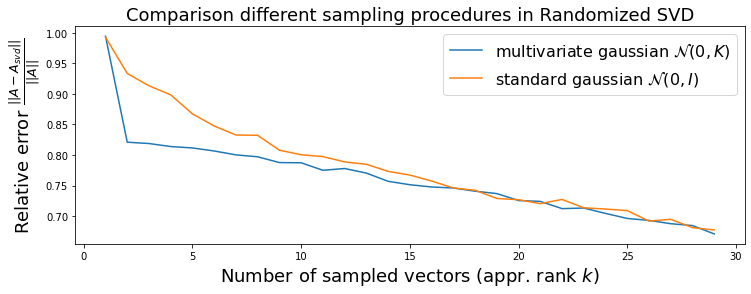

In [502]:
plt.figure(figsize=(12, 4))

plt.plot(k_values, gaussian_errors, label=r'multivariate gaussian $\mathcal{N}(0, K)$')
plt.plot(k_values, random_errors, label=r'standard gaussian $\mathcal{N}(0, I)$')

plt.title('Comparison different sampling procedures in Randomized SVD', fontsize=18)
plt.xlabel('Number of sampled vectors (appr. rank $k$)', fontsize=18)
plt.ylabel(r'Relative error $\frac{||A - A_{svd}||}{||A||} $', fontsize=18)

plt.legend( fontsize=16)
plt.show()

In this experiment we used the discretized Green function of the negative Laplace operator as the covariance matrix $K$. This matrix incorporate some knowledge about diffusion term in the expression $\mathcal{L}u = d^2u / dx^2 - C \cdot \sin(Kx)\cdot u$, $x \in [0, 1]$.

As wee can see on the graphic above, the usage of non-standard kernel allows us to obtain more precise results in case of $k \le 15$.

So, we make some experiments and obtain that In some cases the usage of non-standard covariance matrices is a powerful tool!



**Operator:**  $\mathcal{L}u = d^2u / dx^2 - C \cdot \sin(Kx)\cdot u$, where $x \in [0, 1]$

**Estimated matrix:** the Green's function of $\mathcal{L}$

**Kernel $K$** is constructed by the Green's function of $\mathcal{\hat{L}}u = -d^2u / dx^2$
